<a href="https://colab.research.google.com/github/BelghmiAmine/chessreader_project_2/blob/main/implementation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
os.getcwd()

'/content'

Let's make a regular PyTorch dataset. We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/ML_project/chessreader_project_2/chessreaderdata/box_data/data.csv')
df = df[['corrected','box']]
df.rename(columns = {"corrected": "text","box": "file_name"}, inplace=True)
df.head()

,text,file_name
0,e4,en_0002_easy_26_b00.png
1,c5,en_0002_easy_26_b01.png
2,Nf3,en_0002_easy_26_b02.png
3,Nc6,en_0002_easy_26_b03.png
4,Bg2,en_0002_easy_26_b04.png


We split up the data into training + testing, using sklearn's train_test_split function.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.125) # 0.125 x 0.8 = 0.1 for validation size

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop = True, inplace = True)

Each element of the dataset should return 2 things:

pixel_values, which serve as input to the model.
labels, which are the input_ids of the corresponding text in the image.
We use TrOCRProcessor to prepare the data for the model. TrOCRProcessor is actually just a wrapper around a ViTFeatureExtractor (which can be used to resize + normalize images) and a RobertaTokenizer (which can be used to encode and decode text into/from input_ids).

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class ChessDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training, validation and evaluation datasets:

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = ChessDataset(root_dir='drive/MyDrive/ML_project/chessreader_project_2/chessreaderdata/box_data/boxes/',
                           df=train_df,
                           processor=processor)
test_dataset = ChessDataset(root_dir='drive/MyDrive/ML_project/chessreader_project_2/chessreaderdata/box_data/boxes/',
                           df=test_df,
                           processor=processor)
validation_dataset = ChessDataset(root_dir='drive/MyDrive/ML_project/chessreader_project_2/chessreaderdata/box_data/boxes/',
                           df=val_df,
                           processor=processor)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of validation examples:", len(validation_dataset))



Number of training examples: 1869
Number of test examples: 535
Number of validation examples: 267


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

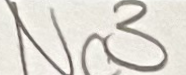

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Nc3


Let's create corresponding dataloaders:

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=4)

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage.

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_model():
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
    model.to(device)
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 64
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    return model

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets.

Character error rate (CER) is a common metric of the performance of an automatic speech recognition (ASR) system. CER is similar to Word Error Rate (WER), but operates on character instead of word.

Character error rate can be computed as:

CER = (S + D + I) / N = (S + D + I) / (S + D + C)

where

S is the number of substitutions,

D is the number of deletions,

I is the number of insertions,

C is the number of correct characters,

N is the number of characters in the reference (N=S+D+C).

CER’s output is not always a number between 0 and 1, in particular when there is a high number of insertions. This value is often associated to the percentage of characters that were incorrectly predicted. The lower the value, the better the performance of the ASR system with a CER of 0 being a perfect score.

In [ ]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.9 MB/s eta 0:00:00


In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-16-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

# We define a range of learning rates we want to test
learning_rates = [1e-5, 2e-5, 5e-5, 1e-4]

best_lr = None # To store the best learning rate
best_average_cer = float('inf') # To store the best character error rate
best_model = None  # To store the best model

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Reset the model to its pre-trained state
    model = load_model()

    # Initialize the optimizer with the current learning rate
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(10): # loop over the dataset multiple times
        # train
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader):
            # get the inputs
            for k,v in batch.items():
                batch[k] = v.to(device)
            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
        print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
        # evaluate on the validation set

        model.eval()
        valid_cer = 0.0
        with torch.no_grad():
            for batch in tqdm(validation_dataloader):
                # run batch generation
                outputs = model.generate(batch["pixel_values"].to(device))
                # compute metrics
                cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
                valid_cer += cer
        average_cer = valid_cer / len(validation_dataloader)
        print(f"Validation Metric for LR {lr} after epoch {epoch}: {average_cer}")
        # Save the best learning rate based on validation performance
        if average_cer < best_average_cer:
            best_average_cer = average_cer
            best_lr = lr
            best_model = model

Training with learning rate: 1e-05


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 0: 0.7741493714225088


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 0: 0.04837910845373533


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 1: 0.4787307757661383


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 1: 0.04953852118031224


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 2: 0.4447642005024812


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 2: 0.053884175525966575


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 3: 0.4139762477805981


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 3: 0.05037524664390335


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 4: 0.3888222666250335


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 4: 0.040599388174015046


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 5: 0.4004198981719649


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 5: 0.05198128985442419


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 6: 0.3962919649023276


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 6: 0.04923409923409924


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 7: 0.3685610193090561


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 7: 0.048585494107882175


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 8: 0.3513152210567242


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 8: 0.05166077703391137


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 9: 0.3672666353229274


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 1e-05 after epoch 9: 0.0750825045601165
Training with learning rate: 2e-05


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 0: 0.7729829624932036


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 0: 0.06108630175794354


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 1: 0.5333100848664076


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 1: 0.08732032892480654


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 2: 0.517946512844318


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 2: 0.0651149223910418


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 3: 0.45525249249787414


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 3: 0.06805570051838708


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 4: 0.4129596843869768


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 4: 0.07363034974975273


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 5: 0.42175469136773014


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 5: 0.0532141987365868


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 6: 0.4692848255682705


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 6: 0.07170950939607655


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 7: 0.4236478194530703


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 7: 0.040839260242245316


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 8: 0.3744426438441643


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 8: 0.05090189661085183


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 9: 0.38357830684409183


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 2e-05 after epoch 9: 0.05218761338164323
Training with learning rate: 5e-05


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 0: 0.9704752262586203


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 0: 0.2342334903902068


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 1: 1.174774440116862


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 1: 1.9369699330520218


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 2: 1.9699346596359188


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 2: 1.631511088414073


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 3: 1.8574793761612003


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 3: 1.4286439928230974


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 4: 1.6734518579438202


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 4: 1.7903513153513144


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 5: 1.4853316481806274


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 5: 1.0731787491115852


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 6: 1.3656067067486608


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 6: 2.2555064338646433


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 7: 1.271171304787326


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 7: 6.948979068195488


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 8: 1.1731703736079044


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 8: 8.271003374734718


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 9: 1.1314998584934788


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 5e-05 after epoch 9: 7.900856916715128
Training with learning rate: 0.0001


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 0: 1.5261068894312932


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 0: 0.5012468874409172


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 1: 0.9837123904472742


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 1: 0.5046528098766906


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 2: 1.7138949053791852


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 2: 1.6311073255103101


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 3: 2.0210094383129706


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 3: 2.2200015780239664


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 4: 1.8018269197553651


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 4: 1.7282301032301035


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 5: 1.4140930636825724


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 5: 4.302215819006864


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 6: 1.2372492367131078


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 6: 7.861377614922393


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 7: 1.162869920205866


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 7: 6.254725374128361


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 8: 1.1045384250390224


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 8: 6.486200118289672


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 9: 1.0426675967681103


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Metric for LR 0.0001 after epoch 9: 7.835041761720869


In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm
# We define a range of learning rates we want to test
learning_rates = [1e-5, 2e-5, 5e-5, 1e-4]

best_lr = None # To store the best learning rate
best_average_cer = float('inf') # To store the best character error rate
best_model = None  # To store the best model

lr = 2e-5
print(f"Training with learning rate: {lr}")

# Reset the model to its pre-trained state
model = load_model()

# Initialize the optimizer with the current learning rate
optimizer = AdamW(model.parameters(), lr=lr)

for epoch in range(10): # loop over the dataset multiple times
        # train
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader):
            # get the inputs
            for k,v in batch.items():
                batch[k] = v.to(device)
            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
        print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
        # evaluate on the validation set

        model.eval()
        valid_cer = 0.0
        with torch.no_grad():
            for batch in tqdm(validation_dataloader):
                # run batch generation
                outputs = model.generate(batch["pixel_values"].to(device))
                # compute metrics
                cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
                valid_cer += cer
        average_cer = valid_cer / len(validation_dataloader)
        print(f"Validation Metric for LR {lr} after epoch {epoch}: {average_cer}")
        # Save the best learning rate based on validation performance
        if average_cer < best_average_cer:
            best_average_cer = average_cer
            best_lr = lr
            best_model = model


Training with learning rate: 2e-05


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/468 [00:00<?, ?it/s]

Loss after epoch 0: 0.7877947194581358


  0%|          | 0/67 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation Metric for LR 2e-05 after epoch 0: 0.047402597402597405


  0%|          | 0/468 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Saving the best model
if best_model is not None:
    best_model.save_pretrained("/content/drive/MyDrive/ML_project/chessreader_project_2/best_model")
    print(f"Best model saved with learning rate: {best_lr}")
else:
    print("No model was saved.")

Best model saved with learning rate: 1e-05


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, RobertaTokenizer
import torch
from PIL import Image
import requests

# Load the model
feature_extractor = ViTFeatureExtractor.from_pretrained('microsoft/trocr-base-stage1')
tokenizer = RobertaTokenizer.from_pretrained('microsoft/trocr-base-stage1')

for idx, row in test_df.iterrows():
    # Load and process the image
    image = Image.open('drive/MyDrive/ML_project/chessreader_project_2/chessreaderdata/box_data/boxes/' + row['file_name'])  # Replace with your image path
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate the prediction
    output_ids = best_model.generate(pixel_values)

    # Decode the prediction
    decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    print("decoded : ",decoded_output)
    print("actual : ",row['text'])


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


decoded :  Bb4
actual :  Bb4
decoded :  Rc1
actual :  Rc1
decoded :  O-O
actual :  O-O
decoded :  b5
actual :  b5
decoded :  Rd8
actual :  Rc8
decoded :  Qc8
actual :  Qc8
decoded :  Qe2
actual :  Qe2
decoded :  Qb4+
actual :  Qb4+
decoded :  c5
actual :  c5
decoded :  Qxb5
actual :  axb5
decoded :  b3
actual :  b3
decoded :  Qg7
actual :  Qg7
decoded :  Kf1
actual :  Kf1
decoded :  b3
actual :  bxc3
decoded :  Qxd4
actual :  Qxd4
decoded :  Bb4
actual :  Bb4
decoded :  Re8
actual :  Re8
decoded :  Nxe5
actual :  Nxe5
decoded :  d6
actual :  d6
decoded :  Ne5
actual :  Ne5
decoded :  d5
actual :  d5
decoded :  exf7+
actual :  exf7+
decoded :  Rxd5
actual :  Rxd5
decoded :  axb4
actual :  axb4
decoded :  Ne5
actual :  Ne5
decoded :  Nb6
actual :  Nb6
decoded :  cxb5
actual :  cxb5
decoded :  Bd8
actual :  Rd8
decoded :  Bxe6
actual :  Bxe6
decoded :  Kf1
actual :  Kf1
decoded :  c5
actual :  cxd5
decoded :  dxe4
actual :  dxe4
decoded :  c5
actual :  c5
decoded :  Rb8
actual :  Rb8
deco

In [ ]:
print('best average cer for lr = 1e-5 is : 0.03888027395490082')

best average cer for lr = 1e-5 is : 0.03888027395490082


In [ ]:
print(best_average_cer)

0.040599388174015046
